###### Image Outlier Detection using Artificial Neural Network

## Introduction

Artificial intelligence is commonly used in various trade circles to automate processes, gather insights on business, and speed up processes. You will use Python to study the usage of artificial intelligence in real-life scenarios - how AI actually impacts industries. 

In Machine Learning, anomaly detection tasks are quite common. Data Scientists are frequently engaged in problems where they have to show, explain and predict anomalies. Detecting anomalies and predicting them beforehand can save a large amount of money. As always, AI can help us in this case. 

In this notebook, we will focus on image outlier detection using artificial neural networks.

## Context

We will be working with dataset showing perfect walls and cracked walls, obtained from [Github](https://github.com/cerlymarco/MEDIUM_NoteBook/tree/master/Anomaly_Detection_Image). Half of the images in the dataset show new and uncorrupted pieces of the wall; the remaining part shows cracks of various dimensions and types.


### Side note: What is VGG?

VGG is a neural network used for large scale image recognition. We will heavily use VGG in this notebook.It was trained on the ImageNet database which has over 14 million hand annotated images.


## Use Python to open csv files

We will use the [scikit-learn](https://scikit-learn.org/stable/), [pandas](https://pandas.pydata.org/), [TensorFlow](https://www.tensorflow.org/), and [Keras](https://keras.io/) libraries to work with our dataset. Scikit-learn is a very useful machine learning library that provides efficient tools for predictive data analysis. TensorFlow and Keras are open source libraries that help in developing and training ML models. Pandas is a popular Python library for data science. It offers powerful and flexible data structures to make data manipulation and analysis easier.


## Import Libraries


In [ ]:
import numpy as np 
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.utils import *

from PIL import Image
import requests
from io import BytesIO
import os
import random
import pickle
import tqdm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Reading the Dataset

We would read the dataset using the Pandas library. Here Crack.json is a json file, where json stands for javascript object notation. A json file uses human-readable text to store and transmit data. In a json file, data are stored in form of attribute value pairs. For an example, there can be a json file storing details on two attributes of a person, which are name and age:

person_details={{name: Sam, age: 20},{name: Ashley, age:19}}

In [ ]:
df = pd.read_json(r'Crack.json', lines=True)
df['label'] = df.annotation.apply(lambda x: x['labels'][0] if len(x['labels'])==1 else 'Crack')
print(df.shape)


(1428, 5)


### Task 1: Print the first few entries of the dataset


In [ ]:
df.head()

,content,annotation,extras,metadata,label
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371420000, 'last_updated...",no Crack
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528373761000, 'last_updated...",Crack
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371146000, 'last_updated...",Crack
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371734000, 'last_updated...",Crack
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528372265000, 'last_updated...",no Crack


In [ ]:
#We can see that the content attribute of dataframe contains the image urls from which images would be
#downloaded. The VGG model takes images of the size 224X224. So, the images are resized and stored in 
#images array

#This operation would take some time to download the images

images = []
for url in tqdm.tqdm(df['content']):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    numpy_img = img_to_array(img)
    img_batch = np.expand_dims(numpy_img, axis=0)
    images.append(img_batch.astype('float16'))
images = np.vstack(images)



100%|██████████| 1428/1428 [02:23<00:00,  9.95it/s]


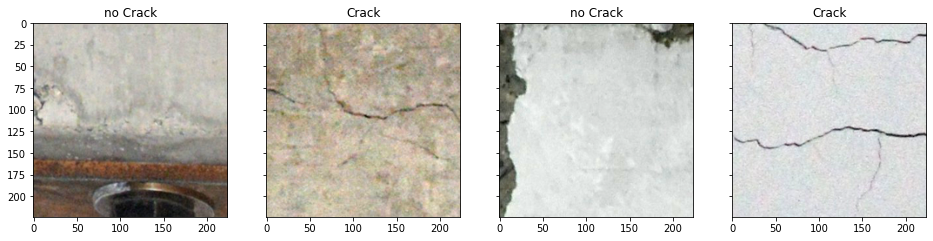

In [ ]:
#Let us display some of the images
random_id = np.random.randint(0,images.shape[0],4)
f, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize = (16,10))

for ax, img, title in zip(axes.ravel(), images[random_id], df['label'][random_id]):
    ax.imshow(array_to_img(img))
    ax.set_title(title)

In [ ]:
#Let us initialize the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))

58892288/58889256 [==============================] - 0s 0us/step



## Training

We will use the VGG model to train our dataset so that we can identify anomalies in the test data. We will use the *softmax* function and *categorical_crossentropy* loss function for this.

The *softmax function* is an exponential function and is used in classification and regression methods. Softmax function outputs a vector that represents the probability distributions of a list of potential outcomes. For more information, see [Softmax](https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d)

Categorical crossentropy is a loss function that is used in classification tasks. Loss function is a measure of how good the classification is. The lower is the loss, the better is the classification. For more details, check [loss](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy)


One *Epoch* is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE. *Batch size* is the total number of training examples present in a single batch.

In [ ]:
#The VGG model has many different layers - convolutional layers, max pooling layers and 
#dense layers. We do not need to take all of them for our computation. We will infact 
#use only the last 8 layers for training our model. So, we make all the other layers 
#except for the last 8 layers non-trainable.

# Let us freeze the layers except the last 8 layers
for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

# Let us check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9097b57860> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f909db74d30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9097b6d860> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9097b6d2b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f909719d9b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f90971676a0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f909716bc88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9097171630> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f90971752b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f90971750b8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f909717a128> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [ ]:
#Y is the label that says crack or no crack and we are converting the crack and no crack labels to
#0 and 1
Y = to_categorical((df.label.values == 'Crack')+0)

In [ ]:
#Let us split the training and test data
X_train, X_test, y_train, y_test = train_test_split(images, Y, random_state = 42, test_size=0.2)

### Task 2: Split the test data such that test size is 0.3 (which means that the training data contains 70% data and test data contains 30% data)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, Y, random_state = 42, test_size=0.3)

In [ ]:
x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation="softmax")(x)

model = Model(vgg_conv.input, x)
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        fill_mode = "nearest",
        zoom_range = 0.3,
        width_shift_range = 0.3,
        height_shift_range=0.3,
        rotation_range=30
)

In [ ]:
train_datagen.fit(X_train)

In [ ]:

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


model = Model(vgg_conv.input, x)
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=20)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
32/31 [==============================] - 954s 30s/step - loss: 0.6854 - accuracy: 0.5956
Epoch 2/20
32/31 [==============================] - 949s 30s/step - loss: 0.6331 - accuracy: 0.7147
Epoch 3/20
32/31 [==============================] - 1025s 32s/step - loss: 0.5764 - accuracy: 0.7497
Epoch 4/20
32/31 [==============================] - 957s 30s/step - loss: 0.5146 - accuracy: 0.7768
Epoch 5/20
 9/31 [=======>......................] - ETA: 10:15 - loss: 0.4495 - accuracy: 0.8229

KeyboardInterrupt: ignored

## Checking accuracy

A confusion matrix is a table that is used to define the performance of a classifier on a set of test data for which the true values are known. 

The accuracy of a machine learning algorithm is a measure of how well the algorithm is performing - how  often the algorithm classifies a data point correctly. Accuracy is given by:

![Accuracy](https://miro.medium.com/max/1050/1*O5eXoV-SePhZ30AbCikXHw.png)

Precision means the % of the results that are relevant, while recall refers to the % of total relevant results correctly classified by an algorithm. 

![Precision and Recall](https://miro.medium.com/max/1050/1*pOtBHai4jFd-ujaNXPilRg.png)

True positive: The model correctly predicts the positive class. 

True negative: The model correctly predicts the negative class.

False positive: The model incorrectly predicts the positive class. 

False negative: The model incorrectly predicts the negative class.


In [ ]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test/255),axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       237
           1       0.87      0.70      0.78       192

    accuracy                           0.82       429
   macro avg       0.83      0.81      0.81       429
weighted avg       0.83      0.82      0.82       429



In [ ]:
### Let us create a function to draw anomalies ###

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [ ]:
def plot_activation(img):
  
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)

    weights = model.layers[-1].get_weights()[0] #weights last classification layer
    class_weights = weights[:, pred_class]

    intermediate = Model(model.input, model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)

    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])

    activation_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(activation_maps.reshape((img.shape[0]*img.shape[1], 512)), class_weights).reshape(img.shape[0],img.shape[1])

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')

    #return out, pred_class

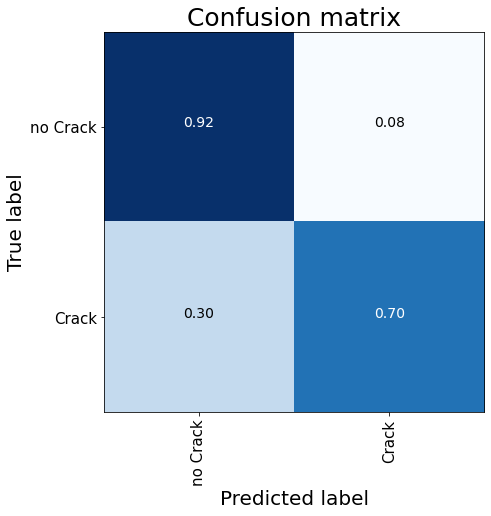

In [ ]:
cnf_matrix = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test/255),axis=1))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=df.label.unique(), title="Confusion matrix")
plt.show()

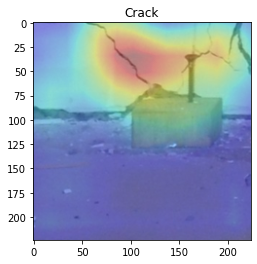

In [ ]:
plot_activation(X_test[200]/255)

### Task 3: Print the activation for the 101st image in the test set. What do you think the red area represents?


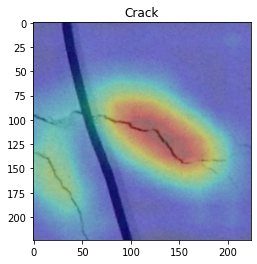

In [ ]:
plot_activation(X_test[100]/255)
#the red area represents if there is a crack

### Conclusion

Here we have seen how AI is being used in anomaly detection. We have trained a neural network to identify cracks in wall images. We can train machine learning system to detect anomalies and reject outliers.